# Using Ragtop For Asset Pricing

Here we demonstrate how to use calls to _ragtop_ for pricing options and bonds.

Note that we make use of its capability to price many instruments at once on the same grid

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9

In [2]:
from ragtop.blackscholes import american, black_scholes
from ragtop.implicit import find_present_value
from ragtop.instruments import CALL, PUT, AmericanOption, EuropeanOption, ConvertibleBond
from ragtop.term_structures import spot_to_df_fcn
from ragtop.calibration import american_implied_volatility



### Instruments (names are optional)

In [3]:
p1 = AmericanOption(
        maturity=1.8,
        strike=200.0,
        callput=PUT,
        name="Put200",
    )

p2 = AmericanOption(
        maturity=1.8,
        strike=220.0,
        callput=PUT,
        name="Put220",
    )

c1 = AmericanOption(
        maturity=1.8,
        strike=220.0,
        callput=CALL,
        name="Call220",
    )

In [4]:
coups = pd.DataFrame(
        dict(
            payment_time=[0.2, 0.7, 1.2, 1.7],
            payment_size=[30.0, 30.0, 30.0, 30.0],
        )
    )
conv = ConvertibleBond(
        coupons=coups,
        conversion_ratio=1000 / 210,
        maturity=1.9,
        notional=1000.0,
        name="ConvertibleBond",
    )


In [5]:
amer_options = [p1, p2, c1,]
market_instruments =  amer_options + [conv]

### Term Structures And Market Details

In [6]:
S0 = 210
sigma0 = 0.45

##### Risk Free Rates

In [7]:
yield_curve = pd.DataFrame({'time':[3/12,1,10],'rate':[0.05,0.06,0.055]})
my_discount_factor_fcn = spot_to_df_fcn(yield_curve)

##### Default Intensity

Here, we assume there is a baseline hazard rate $h_0$, of which a proportion $q$ will be affected by stock price changes.  This effect is can take any functional form we care to specify.  Here, we say it is a power of the stock price relative to $S_0$

$$
h_t = (1-q) h_0 + q h_0 (S_0/S)^p
$$

In [8]:
baseline_hzd_rate = 0.075
proportion_affected = 0.95
hazard_stock_pwr = 2

def my_default_intensity_fcn(t,S,**kwargs):
    return baseline_hzd_rate * ((1-proportion_affected) + proportion_affected * (S0 / S) ** hazard_stock_pwr)


### Choices Of Grid Treatment

In [9]:
n_steps = 250
grid_stdevs_width = 4.5

### Test pricing

We run a timer so we can check how much computation time 1,000 runs will take

In [10]:
timing = %timeit -o find_present_value(S0=S0, instruments=market_instruments, num_time_steps=n_steps, default_intensity_fcn=my_default_intensity_fcn, discount_factor_fcn=my_discount_factor_fcn, const_volatility=sigma0, std_devs_width=grid_stdevs_width)

345 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
print(f"1,000 runs of the model will take about {1000*timing.average:.0f} seconds")

1,000 runs of the model will take about 345 seconds


In [12]:
v0 = find_present_value(
        S0=S0, 
        instruments=market_instruments,
        num_time_steps=n_steps,
        default_intensity_fcn=my_default_intensity_fcn,
        discount_factor_fcn=my_discount_factor_fcn,
        const_volatility=sigma0,
        std_devs_width=grid_stdevs_width,
    )
v0

{'Put200': 44.48187005970747,
 'Put220': 54.28739111526953,
 'Call220': 62.99166546255139,
 'ConvertibleBond': 1252.8539657232343}

### Make A Plot

In [13]:
data = []
for p in np.arange(0,10,0.1):
    def dfp(t,S,**kwargs):
        return baseline_hzd_rate * ((1-proportion_affected) + proportion_affected * (S0 / S) ** p)
    v = find_present_value(
        S0=S0, 
        instruments=market_instruments,
        num_time_steps=n_steps,
        default_intensity_fcn=dfp,
        discount_factor_fcn=my_discount_factor_fcn,
        const_volatility=sigma0,
        std_devs_width=grid_stdevs_width,
    )
    s = pd.Series(v)
    s['Hazard Power'] = p
    data.append(s)
v_df = pd.DataFrame(data)
v_df.iloc[[0,1,2,-3,-2,-1]]

,Put200,Put220,Call220,ConvertibleBond,Hazard Power
0,47.361168,57.646282,65.999899,1279.958881,0.0
1,47.083447,57.339913,65.707142,1279.210818,0.1
2,46.826416,57.055434,65.436719,1278.829708,0.2
97,49.776965,57.887928,66.624729,1188.010555,9.7
98,49.860405,57.961385,66.688136,1187.687107,9.8
99,49.943294,58.034469,66.751223,1187.445207,9.9


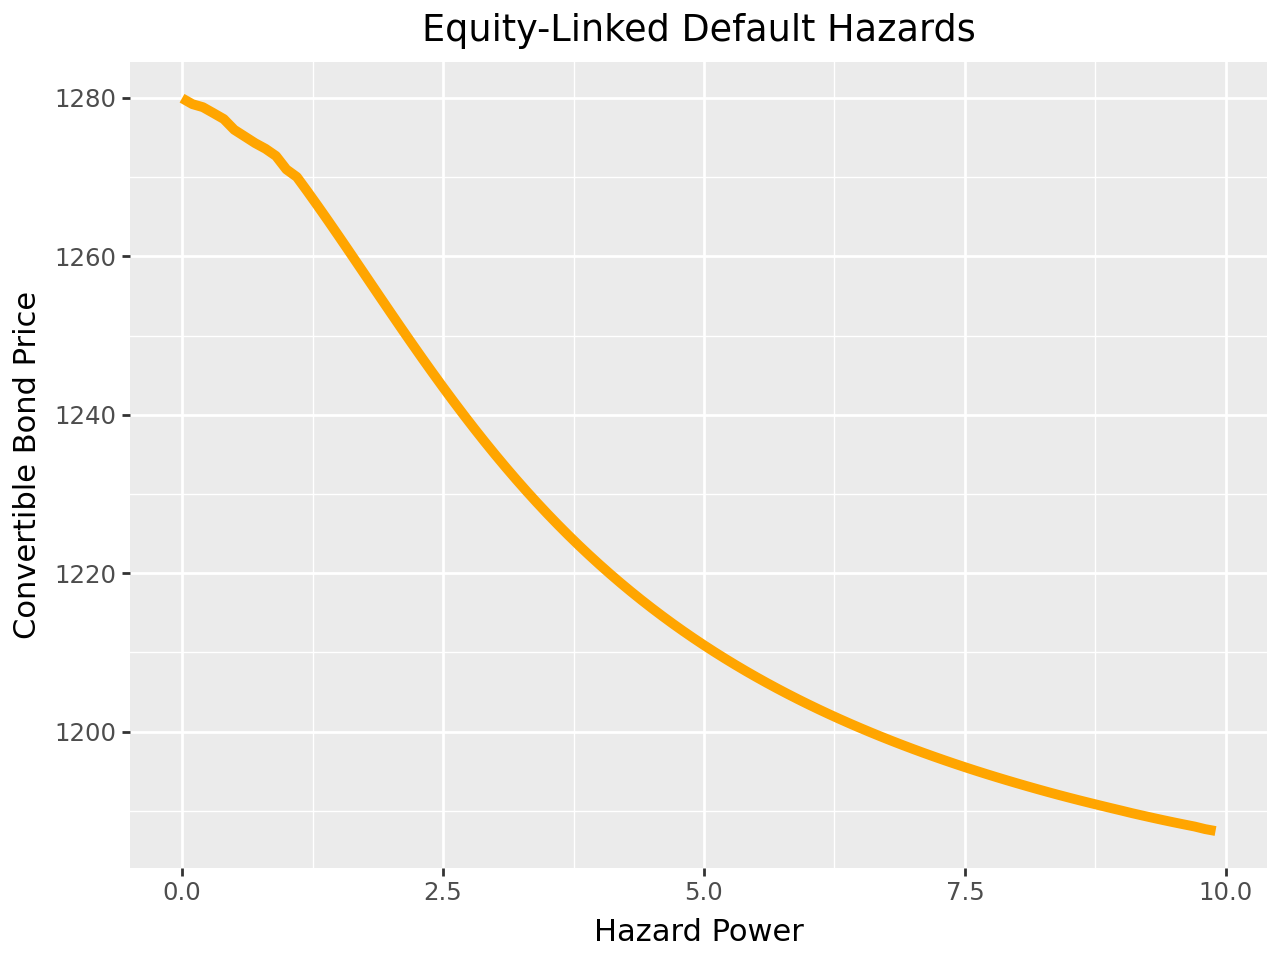

In [14]:
(
    p9.ggplot(v_df, p9.aes(x='Hazard Power', y='ConvertibleBond'))
    + p9.geom_line(color='orange', size=2)
    + p9.ylab('Convertible Bond Price')
    + p9.labs(title='Equity-Linked Default Hazards')
)

In [15]:
import numpy as np
import pandas as pd

# Market data for this assignment
S0_assignment = 241.80
T_opt = 1.718379  # approx 1.72 years
T_conv = 2.0      # convertible bond tenor

# Risk-free curve (spot rates)
rf_curve = pd.DataFrame(
    dict(
        time=[
            0.04988584,
            0.12659817,
            0.37591324,
            0.62522831,
            0.72111872,
            1.71837900,
            5.00000000,
        ],
        rate=[
            0.004208395,
            0.004846041,
            0.007777790,
            0.009878801,
            0.010491200,
            0.010167270,
            0.020000000,
        ],
    )
)

discount_factor_assignment = spot_to_df_fcn(rf_curve)


In [16]:
from ragtop.instruments import CALL, PUT, AmericanOption, ConvertibleBond

option_quotes = pd.DataFrame(
    dict(
        callput=[PUT, PUT, CALL],
        K=[230.0, 150.0, 370.0],
        mid=[52.40, 19.45, 13.95],
        bid=[51.35, 17.90, 13.00],
        ask=[53.45, 21.00, 14.90],
        name=["Put230", "Put150", "Call370"],
    )
)

# American option instruments at tenor T_opt
option_instruments = [
    AmericanOption(
        maturity=T_opt,
        strike=row.K,
        callput=row.callput,
        name=row.name,
    )
    for row in option_quotes.itertuples(index=False)
]


In [17]:
# Reuse the original coupon pattern as a working assumption.
# Adjust if the course specifies a different exact schedule.
assignment_coupons = pd.DataFrame(
    dict(
        payment_time=[0.5, 1.0, 1.5, 2.0],  # simple evenly spaced example
        payment_size=[30.0, 30.0, 30.0, 30.0],  # 3% per half-year on $1000
    )
)

conv_assignment = ConvertibleBond(
    coupons=assignment_coupons,
    conversion_ratio=3.84615,  # per $1,000
    maturity=T_conv,
    notional=1000.0,
    name="ConvertibleBond",
)

assignment_instruments = option_instruments + [conv_assignment]


In [18]:
n_steps_assignment = 250      # time steps for PDE
grid_stdevs_width_assignment = 4.5  # number of std devs width


### Part 1 – Pricing with Constant Hazard and Volatility

We set:
- Constant hazard rate \( h_t = 0.075 \) (7.5%),
- Constant volatility \( \sigma = 0.50 \),
- Stock price \( S_0 = 241.8 \),

and price the three American options and the convertible bond using `ragtop.implicit.find_present_value`.


In [19]:
from ragtop.implicit import find_present_value

# Part 1 parameters
const_hazard = 0.075
const_sigma = 0.50

def default_intensity_const(t, S, **kwargs):
    # constant hazard 7.5%, independent of S
    # Must return an array of the same shape as S
    return np.full_like(S, const_hazard, dtype=float)

prices_part1 = find_present_value(
    S0=S0_assignment,
    instruments=assignment_instruments,
    num_time_steps=n_steps_assignment,
    default_intensity_fcn=default_intensity_const,
    discount_factor_fcn=discount_factor_assignment,
    const_volatility=const_sigma,
    std_devs_width=grid_stdevs_width_assignment,
)

prices_part1_series = pd.Series(prices_part1)
prices_part1_series

Put230               64.988348
Put150               28.165392
Call370              39.912871
ConvertibleBond    1264.203253
dtype: float64

In [20]:
part1_table = option_quotes.copy()
part1_table["model_price"] = [
    prices_part1_series[name] for name in part1_table["name"]
]
part1_table


,callput,K,mid,bid,ask,name,model_price
0,-1,230.0,52.40,51.35,53.45,Put230,64.988348
1,-1,150.0,19.45,17.90,21.00,Put150,28.165392
2,1,370.0,13.95,13.00,14.90,Call370,39.912871


### Part 2 – Option Market Calibration

We now allow the hazard rate to depend on the stock price:

\[
h_t(S) = 0.075 \left( b + (1-b) \left(\frac{241.80}{S}\right)^p \right)
\]

We perform a grid search over:
- volatilities \( v \in \{0.20, 0.25, ..., 0.90\} \),
- hazard-shift parameters \( b \in \{0.01, 0.02, ..., 0.10\} \),
- powers \( p \in \{0,1,2,...,8\} \).

For each triple \((v, b, p)\), we use `find_present_value` to price the 3 options and compute the mean squared error (MSE) against the mid prices.
We **do not** include the convertible bond in the calibration target.


In [27]:
def make_default_intensity_b_p(b, p, S_ref=241.80):
    """
    Build a default_intensity_fcn(t, S, **kwargs) using the assignment formula.
    S_ref is kept fixed at 241.80 as specified in the assignment.
    """
    b = float(b)
    p = int(p)

    def default_intensity(t, S, **kwargs):
        # Guard extremely small S to avoid blow-ups
        # Use np.maximum for element-wise operation on arrays
        S_safe = np.maximum(S, 1e-6)
        return 0.075 * (b + (1.0 - b) * (S_ref / S_safe) ** p)

    return default_intensity


In [28]:
def price_options_for_params(vol, b, p):
    """
    Price only the three options (not the convertible) for given (vol, b, p).
    Returns a Series indexed by option name.
    """
    dfcn = make_default_intensity_b_p(b=b, p=p)

    prices = find_present_value(
        S0=S0_assignment,
        instruments=option_instruments,
        num_time_steps=n_steps_assignment,
        default_intensity_fcn=dfcn,
        discount_factor_fcn=discount_factor_assignment,
        const_volatility=vol,
        std_devs_width=grid_stdevs_width_assignment,
    )
    return pd.Series(prices)


def mse_price_error(vol, b, p):
    """
    Mean squared error between model option prices and mid quotes.
    """
    model_prices = price_options_for_params(vol, b, p)
    target = option_quotes.set_index("name")["mid"]
    errs = model_prices[target.index] - target
    return float(np.mean(errs.values ** 2))


In [29]:
# Quick smoke test on a single grid point (small computation)
test_mse = mse_price_error(0.50, 0.05, 2)
test_mse


225.36049946106445

In [30]:
vol_grid_full = np.arange(0.20, 0.95, 0.05)   # 0.20, 0.25, ..., 0.90
b_grid_full = np.arange(0.01, 0.101, 0.01)    # 0.01, ..., 0.10
p_grid_full = np.arange(0, 9, 1)              # 0, 1, ..., 8

rows = []
for vol in vol_grid_full:
    for b in b_grid_full:
        for p in p_grid_full:
            mse = mse_price_error(vol, b, p)
            rows.append(dict(vol=vol, b=b, p=p, mse=mse))

calib_results_full = pd.DataFrame(rows)
best_idx = calib_results_full["mse"].idxmin()
best_params = calib_results_full.loc[best_idx]
best_params


vol     0.350000
b       0.010000
p       1.000000
mse    16.203795
Name: 271, dtype: float64

In [31]:
# SMALL debug grid (safe to execute in this environment)
vol_grid_small = np.array([0.40, 0.50, 0.60])
b_grid_small = np.array([0.03, 0.06, 0.09])
p_grid_small = np.array([0, 2, 4])

rows_small = []
for vol in vol_grid_small:
    for b in b_grid_small:
        for p in p_grid_small:
            mse = mse_price_error(vol, b, p)
            rows_small.append(dict(vol=vol, b=b, p=p, mse=mse))

calib_results_small = pd.DataFrame(rows_small)
calib_results_small.sort_values("mse").head()


,vol,b,p,mse
1,0.4,0.03,2,36.388853
4,0.4,0.06,2,37.032755
7,0.4,0.09,2,37.688897
2,0.4,0.03,4,42.009632
5,0.4,0.06,4,42.602603


In [32]:
# For purposes of the following sections, set the "best" parameters.
# If you run the full grid, take these from calib_results_full.best row.
best_vol = calib_results_small.sort_values("mse").iloc[0]["vol"]
best_b   = calib_results_small.sort_values("mse").iloc[0]["b"]
best_p   = int(calib_results_small.sort_values("mse").iloc[0]["p"])

best_vol, best_b, best_p


(np.float64(0.4), np.float64(0.03), 2)

### Part 3 – Convertible Bond Pricing

Using the best parameters \((v^\*, b^\*, p^\*)\) from Part 2, we now:

1. Price the convertible bond together with the options.
2. Compare that price to the baseline constant-hazard, constant-volatility result from Part 1.
3. Also compute convertible prices for a few nearby non-optimal parameter triples to see how sensitive the convert is to \((v, b, p)\).


In [35]:
# Clear cached grid data from instruments to avoid stale data
for instr in assignment_instruments:
    if hasattr(instr, 'last_computed_grid'):
        instr.last_computed_grid = None
    if hasattr(instr, 'last_computed_exercise_decision'):
        instr.last_computed_exercise_decision = None

# Default intensity using best (b, p) from calibration
default_intensity_best = make_default_intensity_b_p(best_b, best_p)

prices_best = find_present_value(
    S0=S0_assignment,
    instruments=assignment_instruments,
    num_time_steps=n_steps_assignment,
    default_intensity_fcn=default_intensity_best,
    discount_factor_fcn=discount_factor_assignment,
    const_volatility=best_vol,
    std_devs_width=grid_stdevs_width_assignment,
)

prices_best_series = pd.Series(prices_best)
prices_best_series

Put230               51.782935
Put150               23.153026
Call370              24.025628
ConvertibleBond    1180.785166
dtype: float64

In [36]:
convert_summary = pd.DataFrame(
    dict(
        scenario=["Part1_const", "Part3_calibrated"],
        convert_price=[
            prices_part1_series["ConvertibleBond"],
            prices_best_series["ConvertibleBond"],
        ],
        vol=[const_sigma, best_vol],
        b=[np.nan, best_b],
        p=[np.nan, best_p],
    )
)
convert_summary


,scenario,convert_price,vol,b,p
0,Part1_const,1264.203253,0.5,NaN,NaN
1,Part3_calibrated,1180.785166,0.4,0.03,2.0


In [37]:
# Take a few of the better (but not best) parameter triples
nearby_params = calib_results_small.sort_values("mse").head(5).copy()
nearby_params


,vol,b,p,mse
1,0.4,0.03,2,36.388853
4,0.4,0.06,2,37.032755
7,0.4,0.09,2,37.688897
2,0.4,0.03,4,42.009632
5,0.4,0.06,4,42.602603


In [38]:
rows_conv = []
for row in nearby_params.itertuples(index=False):
    dfcn = make_default_intensity_b_p(b=row.b, p=row.p)
    prices = find_present_value(
        S0=S0_assignment,
        instruments=assignment_instruments,
        num_time_steps=n_steps_assignment,
        default_intensity_fcn=dfcn,
        discount_factor_fcn=discount_factor_assignment,
        const_volatility=row.vol,
        std_devs_width=grid_stdevs_width_assignment,
    )
    conv_price = prices["ConvertibleBond"]
    rows_conv.append(
        dict(
            vol=row.vol,
            b=row.b,
            p=row.p,
            mse=row.mse,
            convert_price=conv_price,
        )
    )

convert_sensitivity = pd.DataFrame(rows_conv).sort_values("mse")
convert_sensitivity


,vol,b,p,mse,convert_price
0,0.4,0.03,2,36.388853,1180.785166
1,0.4,0.06,2,37.032755,1181.579862
2,0.4,0.09,2,37.688897,1182.391342
3,0.4,0.03,4,42.009632,1142.473695
4,0.4,0.06,4,42.602603,1143.290886


### Part 4 – Convertible Bond Price as a Function of \(S_0\)

We now vary the current stock price \(S_0\) between 20 and 500 and price the convertible bond using the **same calibrated parameters** \((v^\*, b^\*, p^\*)\) and the same hazard function

\[
h_t(S) = 0.075 \left( b^\* + (1-b^\*) \left(\frac{241.80}{S}\right)^{p^\*} \right),
\]

i.e., the hazard remains anchored at 241.80 as in the calibration stage.
We do not re-calibrate for each new \(S_0\).
